In [1]:
import sys

import numpy as np
import astropy.units as u
from ndcube import NDCube
import astropy.wcs
import distributed
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ImageNormalize, LogStretch
import sunpy.map

from overlappy.reproject import reproject_to_overlappogram
from overlappy.util import color_lat_lon_axes, strided_array
from overlappy.io import read_overlappogram

sys.path.append('../../')
from mocksipipeline.util import read_data_cube
from mocksipipeline.detector.response import Channel, SpectrogramChannel, convolve_with_response

# Pinhole Images

Testing modeling of the pinhole images.

We should place these all on the same detector, i.e. we should reproject to the same array and adjust the reference pixel accordingly

In [2]:
client = distributed.Client()

2022-09-15 13:18:43,062 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-3xgd3mqt', purging
2022-09-15 13:18:43,063 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-r8yyk7qt', purging
2022-09-15 13:18:43,063 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-_r2i93zy', purging
2022-09-15 13:18:43,063 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-0zcamurj', purging
2022-09-15 13:18:43,063 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-l6lo3ubs', purging


In [3]:
spectral_cube = read_data_cube('moxsi-spectral-cube-ar.fits', hdu=1)

In [4]:
observer = astropy.wcs.utils.wcs_to_celestial_frame(spectral_cube.wcs).observer

In [5]:
selected_filters = [
    'Be_thin',
    'Be_med',
    'Be_thick',
    'Al_poly',
]
chan_filename = '../../mocksipipeline/data/MOXSI_effarea.genx'
pinhole_channels = [Channel(f, chan_filename) for f in selected_filters]

In [6]:
dispersed_orders = [SpectrogramChannel(o, chan_filename) for o in [0,1,3]]

In [7]:
for ph in dispersed_orders + pinhole_channels:
    print('-----------')
    print(ph.name)
    print(f'Filter: {ph._data["filter_desc"]}')
    print(f'Grating: {ph._data["grating_desc"]}')

-----------
MOXSI_S0
Filter: 100 nm of Al based on conversation with Amir 11/11/20
Grating: zero order transmission of grating * polyimide, 11/11/20
-----------
MOXSI_S1
Filter: 100 nm of Al based on conversation with Amir 11/11/20
Grating: first order transmission of grating * polyimide, 11/11/20
-----------
MOXSI_S3
Filter: 100 nm of Al based on conversation with Amir 11/11/20
Grating: third order transmission of grating * polyimide, 11/11/20
-----------
Be_thin
Filter: 9 micron Be filter / XRT thin Be - no support
Grating: no grating
-----------
Be_med
Filter: 30 micron Be filter / XRT med Be - no support
Grating: no grating
-----------
Be_thick
Filter: 300 micron Be filter / XRT thick Be - no support
Grating: no grating
-----------
Al_poly
Filter: 1.25 micron Al filter * 2.5 micron Poly / XRT Al-Poly
Grating: no grating


In [9]:
pinhole_window = 475
margin = 50

In [ ]:
pinhole_images = {}
for i, ph in enumerate(pinhole_channels):
    ph_cube = convolve_with_response(spectral_cube, ph, include_gain=False)
    pinhole_images[ph.name] = reproject_to_overlappogram(
        ph_cube,
        ph.detector_shape,
        observer=observer,
        reference_pixel=(
            margin + pinhole_window*i + (pinhole_window + 1)/2,
            (ph.detector_shape[0] + 1)/2,
            1,
        )*u.pix,
        reference_coord=(
            0*u.arcsec,
            0*u.arcsec,
            ph_cube.axis_world_coords(0)[0].to('angstrom')[0],
        ),
        scale=(
            ph.resolution[0],
            ph.resolution[1],
            ph.spectral_resolution,
        ),
        roll_angle=-90*u.deg,
        dispersion_angle=0*u.deg,
        order=ph.spectral_order,
        meta_keys=['CHANNAME'],
        use_dask=True,
        sum_over_lambda=True,
        algorithm='interpolation'
    )

In [12]:
def get_composite_pinhole_image(images, ref_key):
    return NDCube(np.array([images[k].data[0] for k in images]).sum(axis=0),
                  wcs=images[ref_key][0].wcs,
                  unit=images[ref_key].unit,
                  meta=images[ref_key].meta)

In [13]:
all_pinholes = get_composite_pinhole_image(pinhole_images, 'Be_thin')

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x13be7a2e0>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x13d9a04f0>)

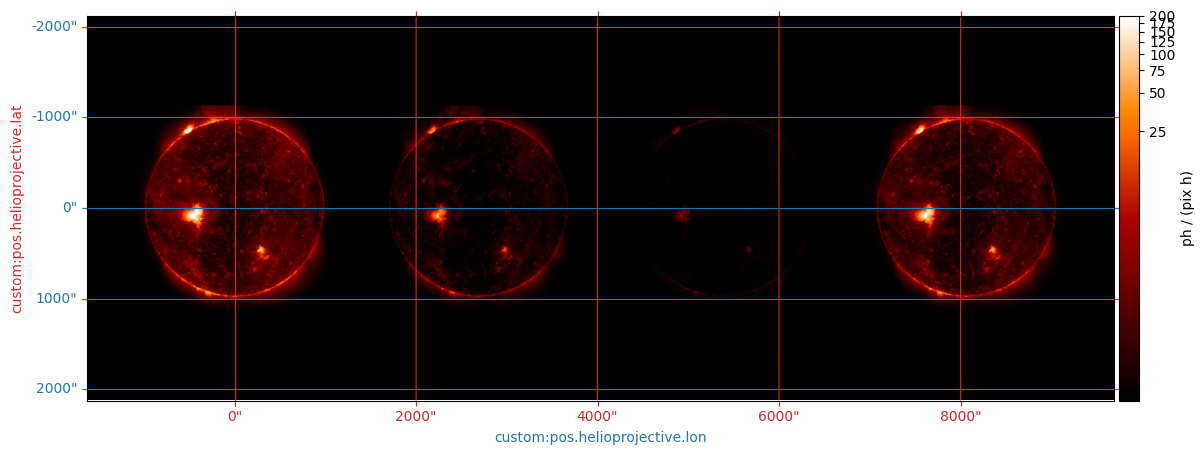

In [14]:
fig = plt.figure(figsize=(15,5))
wave_index = 0
ax = fig.add_subplot(111, projection=all_pinholes.wcs)
plot_unit = 'ph / (pix h)'
#vmin, vmax = AsymmetricPercentileInterval(1,99.5).get_limits(
#    u.Quantity(total_overlap[wave_index].data, total_overlap.unit).to_value(plot_unit),
#)
all_pinholes.plot(
    axes=ax,
    cmap='hinodexrt',
    norm=ImageNormalize(vmin=1e-2, vmax=2e2, stretch=LogStretch()),
    data_unit=plot_unit
)
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)

In [17]:
overlappogram_components = {
    -3: read_overlappogram('overlappogram-ar-photons-order=-3.fits'),
    -1: read_overlappogram('overlappogram-ar-photons-order=-1.fits'),
    0: read_overlappogram('overlappogram-ar-photons-order=0.fits'),
    1: read_overlappogram('overlappogram-ar-photons-order=1.fits'),
    3: read_overlappogram('overlappogram-ar-photons-order=3.fits'),
}

In [18]:
def get_full_overlappogram(components, order):
    data = np.array([components[k].data[0] for k in components]).sum(axis=0)
    wcs = components[order].wcs
    data_strided = strided_array(data, components[order].data.shape[0])
    return NDCube(data_strided, wcs=wcs, unit=components[order].unit, meta=components[order].meta)

In [19]:
dispersed_image = get_full_overlappogram(overlappogram_components, 0)

In [20]:
full_detector = np.vstack([dispersed_image[0].data,all_pinholes.data, ])

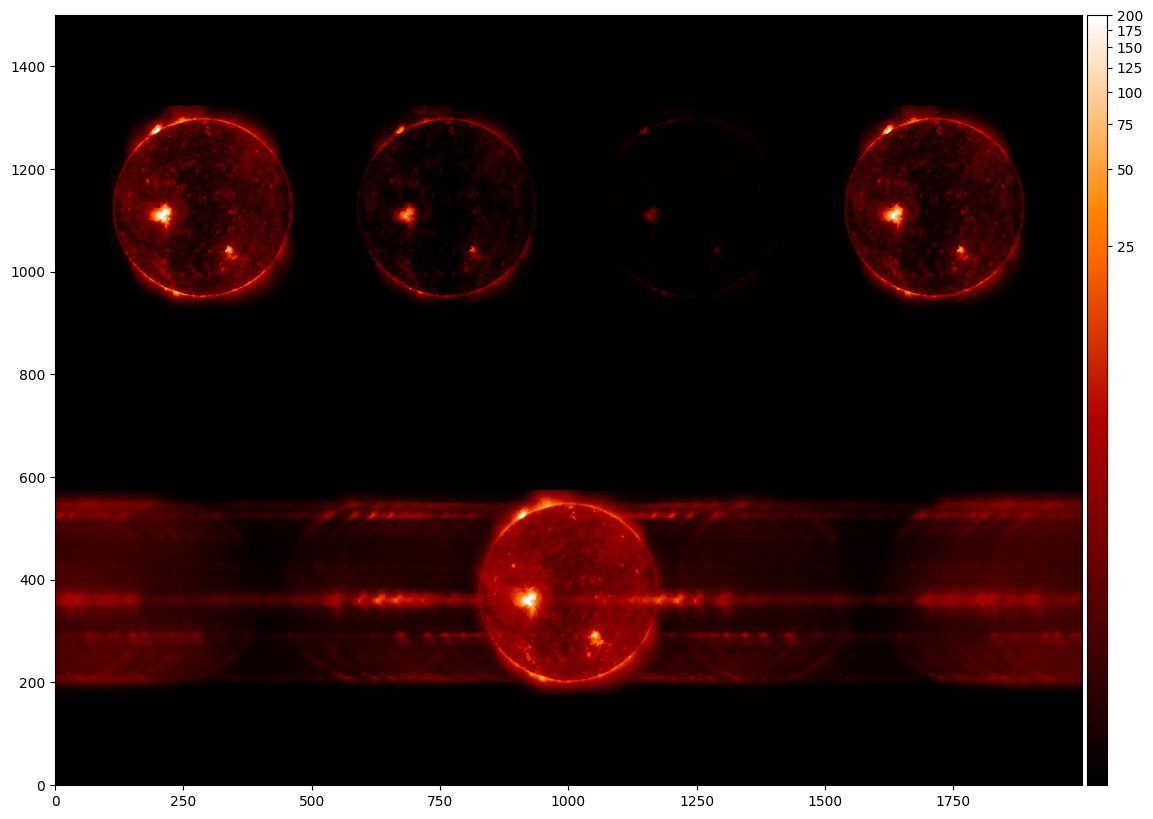

In [21]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
im = ax.imshow((full_detector*dispersed_image.unit).to('ph / pix / h'),
           origin='lower',
           cmap='hinodexrt',
           norm=ImageNormalize(vmin=1e-2, vmax=2e2, stretch=LogStretch())
          )
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")

In [25]:
475*u.pix - (0.5*u.deg / pinhole_channels[0].resolution[0]).to('pix')

<Quantity 156.97879859 pix>